<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/rvvZiR).**

In [245]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

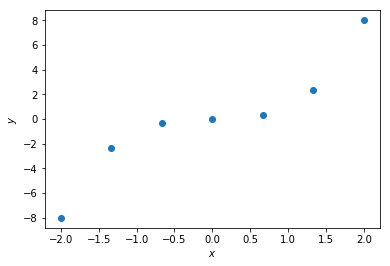

In [246]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график.

-2.53765262771e-16


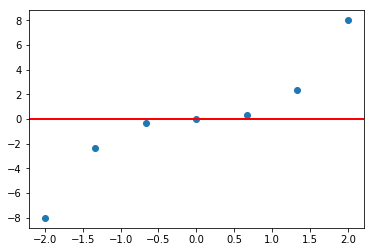

In [247]:
plt.scatter(X, y)
print(np.mean(y))
plt.axhline(y=np.mean(y), linewidth=2, color = 'red')

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

-3.55555555556 2.66666666667 7


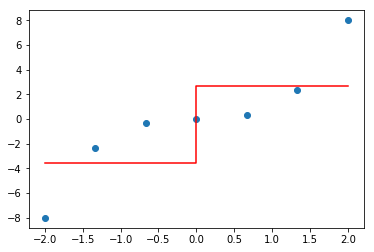

In [248]:
m1 = np.mean(y[X<0])
m2 = np.mean(y[X>=0])
print(m1, m2, len(y))
plt.scatter(X, y)
#plt.axhline(y=m1, xmin=0, xmax=0.5, linewidth=2, color = 'red')
#plt.axhline(y=m2, xmin=0.5, xmax=1, linewidth=2, color = 'red')
plt.plot([-2, 0, 0, 2], [m1, m1, m2, m2], color = "red")

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [249]:
def regression_var_criterion(X, y, t):
    arleft = y[np.where(X<t)]
    arright = y[np.where(X>=t)]
#    print(len(arleft), len(arright))
    if (len(arleft) == 0) or (len(arright) == 0):
        return(0)
    else:
        return(np.var(y) - len(arleft)*np.var(arleft)/len(X) - len(arright)*np.var(arright)/len(X))

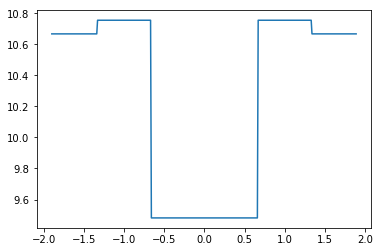

In [191]:
myx = np.arange(-1.9, 1.9, 0.01)
myy = [regression_var_criterion(X, y, x) for x in myx]
plt.plot(myx, myy)


**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

-3.55555555556 2.66666666667 7
-8.0 -1.33333333333 0.888888888889 8.0


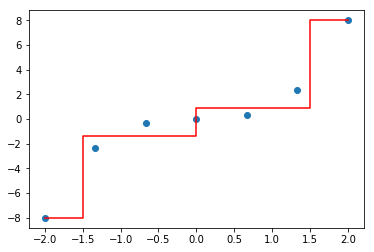

In [250]:
m1 = np.mean(y[np.where(X<0)])
m2 = np.mean(y[np.where(X>=0)])
print(m1, m2, len(y))
m21 = np.mean(y[np.where(X<-1.5)])
m22 = np.mean(y[np.where((X>=-1.5) & (X<0))])
m23 = np.mean(y[np.where((X>=0) & (X<1.5))])
m24 = np.mean(y[np.where(X>=1.5)])
print(m21, m22, m23, m24)   
plt.scatter(X, y)
plt.plot([-2, -1.5, -1.5, 0, 0, 1.5, 1.5, 2], [m21, m21, m22, m22, m23, m23, m24, m24], color = "red")

**<font color='red'>Вопрос 2.</font> Из скольки отрезков состоит график, изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [251]:
df = pd.read_csv('D:\\Yorko\\mlcourse_open\\data\\mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [252]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах", а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`.

In [253]:
df['age_years'] = (df['age'] // 365.25).astype(int)
chol = pd.get_dummies(df['cholesterol'])
gluc = pd.get_dummies(df['gluc'])
#print(chol.describe(), gluc.describe())
df['chol1'] = chol.iloc[:,0]
df['chol2'] = chol.iloc[:,1]
df['chol3'] = chol.iloc[:,2]
df['gluc1'] = gluc.iloc[:,0]
df['gluc2'] = gluc.iloc[:,1]
df['gluc3'] = gluc.iloc[:,2]
print(df.head())

      age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                          
0   18393       2     168    62.0    110     80            1     1      0   
1   20228       1     156    85.0    140     90            3     1      0   
2   18857       1     165    64.0    130     70            3     1      0   
3   17623       2     169    82.0    150    100            1     1      0   
4   17474       1     156    56.0    100     60            1     1      0   

    alco  active  cardio  age_years  chol1  chol2  chol3  gluc1  gluc2  gluc3  
id                                                                             
0      0       1       0         50      1      0      0      1      0      0  
1      0       1       1         55      0      0      1      1      0      0  
2      0       0       1         51      0      0      1      1      0      0  
3      0       1       1         48      1      0      0    

Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [254]:
X_train, X_valid, y_train, y_valid = train_test_split(df[['gender',  'height',  'weight',  'ap_hi',  'ap_lo',
                                                         'smoke', 'alco',  'active',
                                                         'age_years',  'chol1',  'chol2',  'chol3',
                                                          'gluc1',  'gluc2',  'gluc3']], 
                                                      df['cardio'], test_size = 0.3, train_size = 0.7, random_state = 17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [255]:
#print(X_train.describe(), X_valid.describe(), y_train.describe(), y_valid.describe())
reg_tree = DecisionTreeClassifier(max_depth=3, random_state=17)
reg_tree.fit(X_train, y_train)
#print(reg_tree.feature_importances_, len(X_train.columns), len(reg_tree.feature_importances_))
print(reg_tree.feature_importances_)
print(X_train.columns[[3, 8, 11]])
print(reg_tree.tree_.children_left)
print(reg_tree.tree_.children_right)
print(reg_tree.tree_.feature)
print(reg_tree.tree_.threshold)

#export_graphviz(tree_grid.best_estimator_, feature_names=df.columns, 
#out_file='D:\\delne.dot', filled=True)

[ 0.          0.          0.          0.82701377  0.          0.          0.
  0.          0.09713461  0.          0.          0.07585162  0.          0.
  0.        ]
Index(['ap_hi', 'age_years', 'chol3'], dtype='object')
[ 1  2  3 -1 -1  6 -1 -1  9 10 -1 -1 13 -1 -1]
[ 8  5  4 -1 -1  7 -1 -1 12 11 -1 -1 14 -1 -1]
[ 3  8 11 -2 -2 11 -2 -2  3 11 -2 -2  3 -2 -2]
[ 129.5   54.5    0.5   -2.    -2.     0.5   -2.    -2.   138.5    0.5
   -2.    -2.   149.5   -2.    -2. ]


**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [256]:
treeres = reg_tree.predict(X_valid)
print(len(treeres), len(y_valid))
print(np.sum(treeres == y_valid))
print(np.sum(treeres == y_valid)/len(treeres))
crossval1 = np.sum(treeres == y_valid)/len(treeres)

21000 21000
15147
0.721285714286


Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [257]:
tree_params = {'max_depth': list(range(2, 11))}
tree_grid = GridSearchCV(DecisionTreeClassifier(max_depth=3, random_state=17), tree_params, 'accuracy', cv = 5)
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

[mean: 0.71551, std: 0.00363, params: {'max_depth': 2}, mean: 0.72771, std: 0.00485, params: {'max_depth': 3}, mean: 0.73069, std: 0.00446, params: {'max_depth': 4}, mean: 0.73110, std: 0.00477, params: {'max_depth': 5}, mean: 0.73220, std: 0.00494, params: {'max_depth': 6}, mean: 0.73008, std: 0.00270, params: {'max_depth': 7}, mean: 0.73037, std: 0.00456, params: {'max_depth': 8}, mean: 0.72800, std: 0.00468, params: {'max_depth': 9}, mean: 0.72627, std: 0.00347, params: {'max_depth': 10}]
{'max_depth': 6}


C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


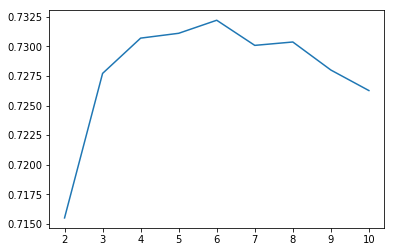

In [258]:
grscores = tree_grid.grid_scores_
len(grscores)
fval = []
sval = []
for j in range(9):
    fval.append(grscores[j][0]['max_depth'])
    sval.append(grscores[j][1])
plt.plot(fval, sval)
print(grscores)
print(tree_grid.best_params_)

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [259]:
print(tree_grid.best_params_)
treeres = tree_grid.predict(X_valid)
print(len(treeres), len(y_valid))
print(np.sum(treeres == y_valid))
print(np.sum(treeres == y_valid)/len(treeres))
crossval2 = np.sum(treeres == y_valid)/len(treeres)
print((crossval2-crossval1)/crossval1)
print(crossval1*0.01, crossval2-crossval1)
print(crossval2/crossval1)
print(crossval1, crossval2)

{'max_depth': 6}
21000 21000
15239
0.725666666667
0.00607380999538
0.00721285714286 0.00438095238095
1.00607381
0.721285714286 0.725666666667


**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева четкий пик, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках.

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [260]:
df2 = df
df2['age1'] = 0
df2['age2'] = 0
df2['age3'] = 0
df2['age4'] = 0
df2.loc[(df2.age_years>=45) & (df2.age_years < 50), 'age1'] = 1
df2.loc[(df2.age_years>=50) & (df2.age_years < 55), 'age2'] = 1
df2.loc[(df2.age_years>=55) & (df2.age_years < 60), 'age3'] = 1
df2.loc[(df2.age_years>=60) & (df2.age_years < 65), 'age4'] = 1
df2['ap1'] = 0
df2['ap2'] = 0
df2['ap3'] = 0
df2.loc[(df2.ap_hi>=120) & (df2.ap_hi < 140), 'ap1'] = 1
df2.loc[(df2.ap_hi>=140) & (df2.ap_hi < 160), 'ap2'] = 1
df2.loc[(df2.ap_hi>=160) & (df2.ap_hi < 180), 'ap3'] = 1
df2['male'] = df2['gender']-1
df2.describe()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,...,gluc2,gluc3,age1,age2,age3,age4,ap1,ap2,ap3,male
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,...,0.074143,0.076157,0.162643,0.244143,0.263900,0.182571,0.536586,0.206229,0.055729,0.349571
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,...,0.262005,0.265251,0.369042,0.429581,0.440749,0.386318,0.498663,0.404599,0.229398,0.476838
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [261]:
dftrain = df2[['age1', 'age2', 'age3', 'age4', 'ap1', 'ap2', 'ap3', 'male', 'chol1', 'chol2', 'chol3', 'smoke']]

In [262]:
dftrain.head()

,age1,age2,age3,age4,ap1,ap2,ap3,male,chol1,chol2,chol3,smoke
id,,,,,,,,,,,,
0,0,1,0,0,0,0,0,1,1,0,0,0
1,0,0,1,0,0,1,0,0,0,0,1,0
2,0,1,0,0,1,0,0,0,0,0,1,0
3,1,0,0,0,0,1,0,1,1,0,0,0
4,1,0,0,0,0,0,0,0,1,0,0,0


In [263]:
treemod = DecisionTreeClassifier(max_depth = 3, random_state=17)
treemodpr = treemod.fit(dftrain, df2['cardio'])

In [240]:
treemodpr.feature_importances_

array([  0.00000000e+00,   2.69702426e-04,   4.97059348e-04,
         0.00000000e+00,   0.00000000e+00,   5.80389328e-01,
         2.48501900e-01,   0.00000000e+00,   4.57631104e-04,
         0.00000000e+00,   1.69830781e-01,   5.35978783e-05])

In [264]:
print(treemodpr.tree_.feature)
print(treemodpr.tree_.threshold)
print(treemodpr.tree_.children_left)
print(treemodpr.tree_.children_right)

[ 5  6 10 -2 -2 11 -2 -2  2  1 -2 -2  8 -2 -2]
[ 0.5  0.5  0.5 -2.  -2.   0.5 -2.  -2.   0.5  0.5 -2.  -2.   0.5 -2.  -2. ]
[ 1  2  3 -1 -1  6 -1 -1  9 10 -1 -1 13 -1 -1]
[ 8  5  4 -1 -1  7 -1 -1 12 11 -1 -1 14 -1 -1]


In [265]:
df2 = X_train
df2['age1'] = 0
df2['age2'] = 0
df2['age3'] = 0
df2['age4'] = 0
df2.loc[(df2.age_years>=45) & (df2.age_years < 50), 'age1'] = 1
df2.loc[(df2.age_years>=50) & (df2.age_years < 55), 'age2'] = 1
df2.loc[(df2.age_years>=55) & (df2.age_years < 60), 'age3'] = 1
df2.loc[(df2.age_years>=60) & (df2.age_years < 65), 'age4'] = 1
df2['ap1'] = 0
df2['ap2'] = 0
df2['ap3'] = 0
df2.loc[(df2.ap_hi>=120) & (df2.ap_hi < 140), 'ap1'] = 1
df2.loc[(df2.ap_hi>=140) & (df2.ap_hi < 160), 'ap2'] = 1
df2.loc[(df2.ap_hi>=160) & (df2.ap_hi < 180), 'ap3'] = 1
df2['male'] = df2['gender']-1
df2.describe()

dftrain = df2[['age1', 'age2', 'age3', 'age4', 'ap1', 'ap2', 'ap3', 'male', 'chol1', 'chol2', 'chol3', 'smoke']]
treemod = DecisionTreeClassifier(max_depth = 3, random_state=17)
treemodpr = treemod.fit(dftrain, y_train)
print(treemodpr.feature_importances_)
print(treemodpr.tree_.feature)

[  0.00000000e+00   2.70410311e-04   4.93438786e-04   0.00000000e+00
   0.00000000e+00   5.69946417e-01   2.53210514e-01   0.00000000e+00
   7.33897746e-04   0.00000000e+00   1.75307927e-01   3.73953705e-05]
[ 5  6 10 -2 -2 11 -2 -2  2  1 -2 -2  8 -2 -2]
